In [8]:
%env TF_CPP_MIN_LOG_LEVEL=3

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datetime
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf

from tqdm.notebook import tqdm

from concurrent.futures import ThreadPoolExecutor

from importlib import reload
import keras_model_creator
import sentinel_utils
import plot_utils
import ee_downloader
from data_generator import DataGenerator

env: TF_CPP_MIN_LOG_LEVEL=3


In [9]:
reload(sentinel_utils)

model_dir = Path('models', 'selected_model')
shards_dir = Path.home().joinpath('sentinel_data', 'shards')

utils = sentinel_utils.SentinelUtils(min_occurrences=10000)

selected_classes = utils.get_processed_labels()

training_years = '2017_2018_2019'
data_summary = utils.get_data_summary(
    selected_classes, training_years=training_years
)

batch_size = 64

model_parent_dir = Path('models')
model_dir = model_parent_dir.joinpath(
    f'hypertuned-{len(selected_classes.index)}'
    f'-{selected_classes.shape[1]}-{batch_size}'
)
model_dir.mkdir(parents=True, exist_ok=True)

params = dict(
    selected_classes=selected_classes,
    data_summary=data_summary,
    model_dir=model_dir,
    batch_size=batch_size,
    years=training_years,
    epochs=10,
    overwrite=True,
    verbose=1,
    print_log=1,    
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [11]:
selected_classes.shape

(243525, 13)

In [3]:
# reload(keras_model_creator)
# model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

In [4]:
y_true = selected_classes.to_numpy()

weather_median = pd.read_csv(Path('weather_data', 'era5_2017.csv'))
weather_median = weather_median.interpolate(method='nearest').ffill().bfill()

eval_years = list(range(2020, 2025))
corrs = []

weather_diffs = []
y_diffs = []

for eval_year in tqdm(eval_years):
    eval_generator = DataGenerator(
        selected_classes.index, shuffle=False, year=eval_year, **params
    )
    preds_path = model_dir.joinpath(f'preds_{eval_year}.npy')
    if preds_path.is_file():
        y_pred = np.load(preds_path)
    else:
        y_pred = model.predict(x=eval_generator, verbose=1)
        np.save(preds_path, y_pred)

    weather = pd.read_csv(Path('weather_data', f'era5_{eval_year}.csv'))
    weather = weather.interpolate(method='nearest').ffill().bfill()

    y_diff = pd.DataFrame(
        y_pred - y_true[:y_pred.shape[0]], 
        columns=selected_classes.columns
    )
    weather_diff = (
        (weather - weather_median)
        .loc[selected_classes.index]
        .iloc[:y_pred.shape[0]]
    )

    weather_diffs.append(weather_diff)
    
    y_diffs.append(y_diff)
    
    # corr = y_diff.join(weather_diff).corr(method='pearson').round(2)
    corr = pd.concat(
        [y_diff, weather_diff], axis=1, keys=['df1', 'df2']
    ).corr().loc['df2', 'df1'].round(2)
    corrs.append(corr)


  0%|          | 0/5 [00:00<?, ?it/s]

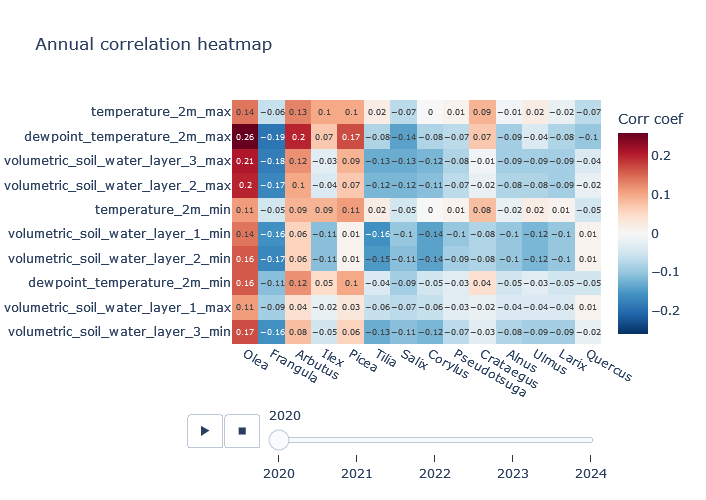

In [7]:
top_genus = pd.concat(corrs).abs().agg('max').sort_values(ascending=False).index[:14].tolist()
top_climate = pd.concat(corrs).T.abs().agg('max').sort_values(ascending=False).index[:14].tolist()

zmax = max([corr.abs().max().max() for corr in corrs])
fig = px.imshow(
    np.array([corr[top_genus].loc[top_climate] for corr in corrs]),
    animation_frame=0,
    labels=dict(color="Corr coef"),
    x=top_genus,
    y=top_climate,
    title='Annual correlation heatmap',
    color_continuous_scale='RdBu_r',
    text_auto=True, aspect='auto', 
    zmin=-zmax, 
    zmax=zmax, 
    height=500
)
fig.layout.sliders[0]['currentvalue']['prefix'] = ''
for year, step in zip(eval_years, fig.layout.sliders[0].steps):
    step.label = str(year)
fig

In [6]:
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler

x_input = Input((14,))

for units in reversed([x**2 for x in range(4, 8)]):
    x = Dense(units, activation='relu')(x_input)
x = Dropout(0.2)(x)
outputs = Dense(y_diffs[0].shape[-1], activation='sigmoid')(x)

m = tf.keras.models.Model(inputs=[x_input], outputs=outputs)
m.compile(optimizer='adam', loss='huber', metrics=['root_mean_squared_error', 'r2_score'])

for weather_diff, y_diff in reversed(list(zip(weather_diffs, y_diffs))):
    hist = m.fit(
        x=StandardScaler().fit_transform(weather_diff), 
        y=y_diff,
        validation_split=0.1,
        epochs=10, verbose=0
    )
    print('val_r2_score', hist.history['val_r2_score'][-1])


val_r2_score 0.05086209252476692
val_r2_score 0.03503693640232086
val_r2_score 0.002100642304867506
val_r2_score -0.0013321297010406852
val_r2_score 0.052994102239608765
